## Exemple pratique 1 : rendements des variétés de blé tendre d'hiver

### Problématique :
On s'intéresse ici à la problématique suivante : 
- Quelles sont les variétés de blés les plus performantes au sein d'Agrosyst ?

On retiendra notamment le rendement en matière sèche comme indicateur de performance.

Ce script propose une façon de mener à bien cet exercice en utilisant l'architecture de l'entrepôt de données. 

### Prérequis :
* Le script suppose d'avoir télécharger les données issues de l'entrepôt sur la plateforme datagrosyt (https://agrosyst.fr/datagrosyst/)

* Le script est rédigé en **Python** et suppose une bonne maîtrise de **pandas** 


#### Import des librairies

In [262]:
import pandas as pd
from tqdm import tqdm
import numpy as np

#### Import des données

In [263]:
# déclaration des chemins de données brutes
folder_base = '/home/bvuittenez/Bureau/utils/data'


# ------------------ #
# IMPORT DES DONNÉES #
# ------------------ #
ENTREPOT_PATH = '~/Bureau/utils/data/' # '/home/administrateur/Documents/datagrosyst_/' # 'data/entrepot_20231115/'
df = {}

def import_df(df_name, path_data, sep, index_col=None):
    df[df_name] = pd.read_csv(path_data+df_name+'.csv', sep = sep, index_col=index_col, low_memory=False)

def import_dfs(df_names, path_data, sep = ',', index_col=None, verbose=False):
    for df_name in tqdm(df_names) : 
        if(verbose) :
            print(" - ", df_name)
        import_df(df_name, path_data, sep, index_col=index_col)

tables_entrepot = [
    'espece', 'variete', 'culture', 'composant_culture', 'recolte_rendement_prix', 'action_synthetise',
    'recolte_rendement_prix_restructure'
]

tables_magasin = [
    'utilisation_intrant_realise_agrege', 'utilisation_intrant_synthetise_agrege', 'intervention_realise_agrege', 'intervention_synthetise_agrege',
    'action_realise_agrege', 'action_synthetise_agrege'
]

# import des données de l'entrepôt avec la colonne 'id' en index 
import_dfs(tables_entrepot, ENTREPOT_PATH, sep = ',', index_col='id', verbose=False)

# import des données du magasin
import_dfs(tables_magasin, ENTREPOT_PATH, sep = ',', verbose=False)

100%|██████████| 6/6 [00:35<00:00,  5.98s/it]


#### Pré-traitement des données

In [151]:
# Définition de la culture étudiée
STUDIED_CULTURE_ACTA = "blé tendre d'hiver"
STUDIED_UNIT = 'TONNE_MS_HA'

# Ajout du nom de la culture acta aux composant de culture
left = df['composant_culture']
right = df['espece'][['nom_culture_acta']]
df['composant_culture_extanded'] = pd.merge(left, right, left_on='espece_id', right_index=True, how='left')

# Ajout du nom de la variete acta aux composant de culture
left = df['composant_culture_extanded']
right = df['variete'][['code_gnis']].rename(columns={'code_gnis' : 'code_gnis_variete'})
df['composant_culture_extanded'] = pd.merge(left, right, left_on='variete_id', right_index=True, how='left')

In [152]:
# Ajout de toutes les informations des composants de cultures à la table de récolte
left = df['recolte_rendement_prix']
right = df['recolte_rendement_prix_restructure']
df['recolte_rendement_prix_extanded'] = pd.merge(left, right, left_index=True, right_index=True, how='left')

left = df['recolte_rendement_prix_extanded'][['commercialisation_pct', 'autoconsommation_pct', 'rendement_moy', 'rendement_unite', 'composant_culture_id', 'prixref', 'prixref_unite']]
right = df['composant_culture_extanded'][['nom_culture_acta', 'code_gnis_variete']]
df['recolte_rendement_prix_extanded'] = pd.merge(left, right, left_on='composant_culture_id', right_index=True, how='left') 

### Sélection des données

In [153]:
# On sélectionne toutes les données qui sont du blé tendre d'hiver et qui ont une variété
df_studied = df['recolte_rendement_prix_extanded'].loc[
    (df['recolte_rendement_prix_extanded']['nom_culture_acta'] == STUDIED_CULTURE_ACTA)
]

In [154]:
# Environ 80% des blés récoltés ont une variété saisie
df_studied['code_gnis_variete'].isna().value_counts(1)

code_gnis_variete
False    0.770147
True     0.229853
Name: proportion, dtype: float64

In [241]:
# On sélectionne uniquement les récoltes avec l'unité étudiée et qui ont une variété de déclaré
df_studied_rendement = df_studied.loc[
    (df_studied['rendement_unite'] == STUDIED_UNIT) &
    (~df_studied['code_gnis_variete'].isna())
]

### Filtres statistiques outliers

In [242]:
# on filtre le  derniers percentiles car erreurs de saisies
percentiles = np.percentile(df_studied_rendement[['rendement_moy']], [0, 99])

df_studied_rendement = df_studied_rendement.loc[
    df_studied_rendement['rendement_moy'].between(percentiles[0], percentiles[1])
]

# on filtre toutes les variétés qui n'ont pas assez de saisie
variete_count = df_studied_rendement['code_gnis_variete'].value_counts()

df_studied_rendement = df_studied_rendement.loc[
    df_studied_rendement['code_gnis_variete'].isin(variete_count.loc[variete_count > 100].index)
]

<AxesSubplot: >

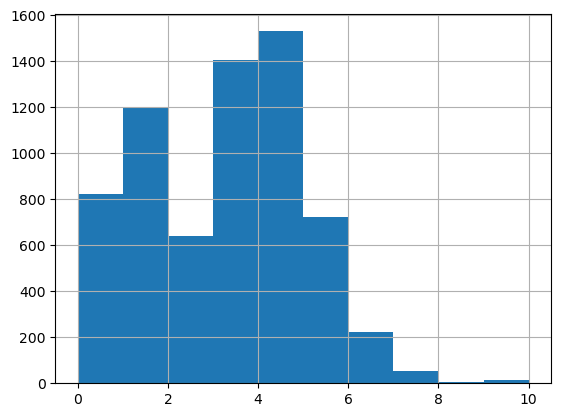

In [243]:
df_studied_rendement['rendement_moy'].hist()

#### Visualisation

In [274]:
import plotly.express as px
fig = px.box(
    df_studied_rendement, 
    x="code_gnis_variete", 
    y="rendement_moy",
    labels={
        "code_gnis_variete": "Code gnis variété",
        "rendement_moy": "Rendement moyen (Tonne de matière sèche /ha)",
    }
)

fig.show()